# *Imports*

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import cv2
import os
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from time import time
import math as m
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt

from scipy.signal import convolve2d

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import validation_curve
import pickle

# *Function to show images inline*

In [3]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

<hr>


# *READING DATA*

In [4]:
images = []
for i in range(1,10):
    for filename in os.listdir("D:/Uni/Semester 9/Pattern/project/ACdata_base/"+str(i)):
        img = cv2.imread(os.path.join("D:/Uni/Semester 9/Pattern/project/ACdata_base/"+str(i),filename))
        if img is not None:
            images.append(rgb2gray(img))
images = np.asarray(images)

(1685,)
(216, 700)


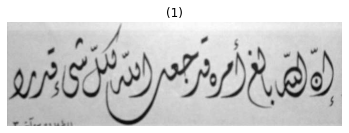

In [5]:
print(images.shape)
print(images[0].shape)
show_images([images[0]])

<hr>


# *Labeling DATA*

In [6]:
y = np.asarray(([1]*190 )+([2]*190 )+([3]*180 )+([4]*185 )+([5]*195 )+([6]*180 )+([7]*185 )+([8]*190 )+([9]*190 ))
print(len(y))
print(images.shape)
y

1685
(1685,)


array([1, 1, 1, ..., 9, 9, 9])

<hr>

# *PREPROCESSING*

### We will use several image preprocessing techniques and choose the best one

In [7]:
test_img = np.copy(images[1528])

binary_global = test_img > threshold_otsu(test_img)

window_size = 25
thresh_niblack = threshold_niblack(test_img, window_size=window_size, k=0.8)
binary_niblack = test_img > thresh_niblack

thresh_sauvola = threshold_sauvola(test_img, window_size=window_size)
binary_sauvola = test_img > thresh_sauvola

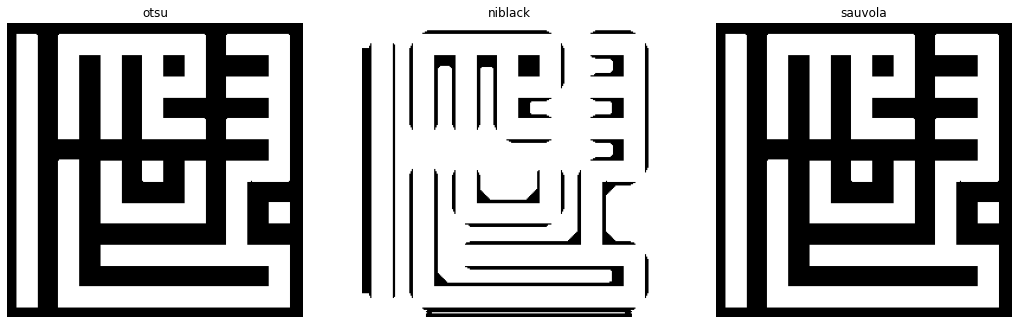

In [8]:
show_images([binary_global,binary_niblack,binary_sauvola],["otsu","niblack","sauvola"])

## Based on the test image output we will use either "sauvola" or "global" as preprocessing method

<hr>
<hr>
<hr>

# *FEATURE EXTRACTION*

##  *L*ocal *P*hase *Q*uantization LPQ: blur insensitive texture descriptor
###  founded on the blur invariance property of the Fourier phase spectrum the local phase information computed over M-by-M neighborhood using the 2-D DFT

In [9]:
def lpq(img, winSize=3, freqestim=1, mode='nh'):
    rho = 0.90

    STFTalpha = 1 / winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    '''
    sigmaS = (winSize - 1) / 4  # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA = 8 / (winSize - 1)  # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)
    '''

    convmode = 'valid'  # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img = np.float64(img)  # Convert np.image to double
    r = (winSize - 1) / 2  # Get radius from window size
    x = np.arange(-r, r + 1)[np.newaxis]  # Form spatial coordinates in window

    if freqestim == 1:  # STFT uniform window
        #  Basic STFT filters
        w0 = np.ones_like(x)
        w1 = np.exp(-2 * np.pi * x * STFTalpha * 1j)
        w2 = np.conj(w1)

    # Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1 = convolve2d(convolve2d(img, w0.T, convmode), w1, convmode)
    filterResp2 = convolve2d(convolve2d(img, w1.T, convmode), w0, convmode)
    filterResp3 = convolve2d(convolve2d(img, w1.T, convmode), w1, convmode)
    filterResp4 = convolve2d(convolve2d(img, w1.T, convmode), w2, convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp = np.dstack([filterResp1.real, filterResp1.imag,
                          filterResp2.real, filterResp2.imag,
                          filterResp3.real, filterResp3.imag,
                          filterResp4.real, filterResp4.imag])

    # Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis, np.newaxis, :]
    LPQdesc = ((freqResp > 0) * (2 ** inds)).sum(2)

    # Switch format to uint8 if LPQ code np.image is required as output
    if mode == 'im':
        LPQdesc = np.uint8(LPQdesc)

    # Histogram if needed
    if mode == 'nh' or mode == 'h':
        LPQdesc = np.histogram(LPQdesc.flatten(), range(256))[0]
#         LPQdesc = np.histogram(LPQdesc.flatten(), range(512))[0]

    # Normalize histogram if needed
    if mode == 'nh':
        LPQdesc = LPQdesc / LPQdesc.sum()

#     print(LPQdesc)
#     plt.plot(LPQdesc)
#     plt.show()
    return LPQdesc

### We tried different number of output LPQ fetures rether than 256.
### Tried to incresed the number of features the accuracy did not change it only took more time to fit (no more info were added so that the model can learn from).
### Tried to decrease the number of features the accuracy got wrose but took less time to fit.

### Computing LPQ features for each input image

In [10]:
def compute_LPQ(img,window_size = 25):
    thresh_sauvola = threshold_sauvola(img, window_size=window_size)
    image_binary_sauvola = img > thresh_sauvola
    return lpq(image_binary_sauvola)

In [11]:
x = []
for i in images:
    x.append(compute_LPQ(i))
print(len(x))

1685


In [12]:
print(len(x[0]))
print(len(x))
print(len(y))

255
1685
1685


<hr>
<hr>

# *TRAINING*
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png" srcset="../../_images/sphx_glr_plot_classifier_comparison_001.png" alt="Input data, Nearest Neighbors, Linear SVM, RBF SVM, Gaussian Process, Decision Tree, Random Forest, Neural Net, AdaBoost, Naive Bayes, QDA" class="sphx-glr-single-img">

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


<hr>


# *Cross Validation*

####  Model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set.


####  To guarantee that the model is not overfitted or the hyperpramters is overfitted too


#### Give the chance that each sample get tested on at some point and that reduces bias 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif">

In [15]:
def cross_validate_train(clf, x, y, k_folds = 5, return_all = True, print_all = True):
    cv_results = cross_validate(clf, x, y, cv=k_folds)
    avrg_fit_time = np.sum(cv_results['fit_time'])/k_folds
    avrg_score_time = (np.sum(cv_results['score_time'])/k_folds)
    avrg_score = (np.sum(cv_results['test_score'])/k_folds)
    
    if print_all:
        print("fit_times:   "+str(cv_results['fit_time'])+", avrg fit time: "+str(avrg_fit_time))
        print("score_times: "+str(cv_results['score_time'])+", avrg score time: "+str(avrg_score_time))
        print("test_scores: "+str(cv_results['test_score'])+", avrg acc: "+str(avrg_score))
    if return_all:
        return avrg_fit_time, avrg_score_time,  avrg_score
    

<hr>

## SVM
### Using test set for hyperparameter tuning for SVM instead of validation test


In [19]:
best_acc = 0
# SVM hyper parameters
# Kernel: Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used.
# C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
best_c = 0
# Gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
best_gamma = 0
for c_i in range(100,500,50):
    for gamma_i in range(1,40,2):
        clf = svm.SVC(C=c_i,gamma=gamma_i,random_state=0)
        
        _,_,temp_acc = cross_validate_train(clf,X_train, y_train,print_all = False)
        
        if temp_acc > best_acc:
            best_acc = temp_acc
            best_c = c_i
            best_gamma = gamma_i
print(best_acc)
print("best c: "+str(best_c))
print("best gamma: "+str(best_gamma))

0.9792399834779018
best c: 400
best gamma: 25


In [ ]:
# 0.9792399834779018
# best c: 400
# best gamma: 25

# *Validation curve*
### First Validation curve for GAMMA 

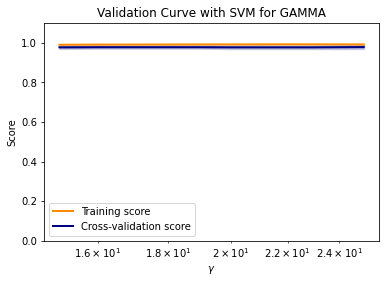

Train scores: [[0.99257885 0.98979592 0.99072356 0.99165894 0.98980538]
 [0.99350649 0.99072356 0.99165121 0.99165894 0.99073216]
 [0.99257885 0.99072356 0.99165121 0.99258573 0.99165894]
 [0.99257885 0.99072356 0.99165121 0.99258573 0.99258573]
 [0.99350649 0.99165121 0.99165121 0.99258573 0.99258573]
 [0.99350649 0.99165121 0.99165121 0.99351251 0.99258573]
 [0.99350649 0.99165121 0.99257885 0.99351251 0.99258573]
 [0.99350649 0.99257885 0.99257885 0.99351251 0.99258573]
 [0.99350649 0.99165121 0.99257885 0.99351251 0.99258573]
 [0.99350649 0.99165121 0.99257885 0.99351251 0.99258573]
 [0.99350649 0.99165121 0.99165121 0.99258573 0.99258573]]
Test scores: [[0.97037037 0.97777778 0.97037037 0.98513011 0.98513011]
 [0.97037037 0.97777778 0.97407407 0.98513011 0.98513011]
 [0.97037037 0.97777778 0.97407407 0.98513011 0.98513011]
 [0.97037037 0.97777778 0.97407407 0.98513011 0.98513011]
 [0.97037037 0.97777778 0.97407407 0.98513011 0.98513011]
 [0.96666667 0.97777778 0.97407407 0.9851301

In [124]:
param_range = np.arange(15,26,1)
train_scores, test_scores = validation_curve(
    svm.SVC(C=400,random_state=0),
    X_train,
    y_train,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM for GAMMA")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

print("Train scores: "+str(train_scores))
print("Test scores: "+str(test_scores))

### Second Validation curve for C 

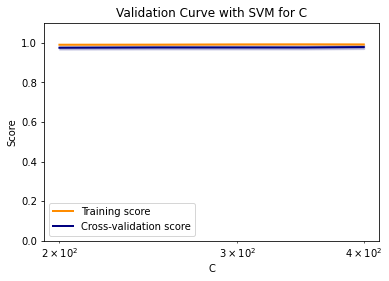

Train scores: [[0.99165121 0.98979592 0.99072356 0.99165894 0.99073216]
 [0.99257885 0.98979592 0.99072356 0.99165894 0.99165894]
 [0.99350649 0.99072356 0.99257885 0.99258573 0.99258573]
 [0.99350649 0.99165121 0.99257885 0.99351251 0.99258573]
 [0.99350649 0.99165121 0.99165121 0.99258573 0.99258573]]
Test scores: [[0.97037037 0.97407407 0.96666667 0.98513011 0.98141264]
 [0.96666667 0.97777778 0.97037037 0.98513011 0.98513011]
 [0.96666667 0.97777778 0.97037037 0.98513011 0.98513011]
 [0.96666667 0.97777778 0.97037037 0.98513011 0.98513011]
 [0.96666667 0.98148148 0.97407407 0.98884758 0.98513011]]


In [125]:
param_range = np.asarray([200,250,300,350,400])
train_scores, test_scores = validation_curve(
    svm.SVC(gamma=25,random_state=0),
    X_train,
    y_train,
    param_name="C",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM for C")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

print("Train scores: "+str(train_scores))
print("Test scores: "+str(test_scores))

# SVM
## <font color='red'>Best fit time: 0.1sec, with good accuracy: 97.9% </font>

In [15]:
t_start = time()
clf = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
cross_validate_train(clf,X_train, y_train)
print("time to fit cross-val: "+str(time()-t_start))

fit_times:   [0.12965155 0.10372376 0.10472012 0.10771108 0.11170077], avrg fit time: 0.11150145530700684
score_times: [0.02692747 0.02692604 0.02892399 0.02792668 0.02593088], avrg score time: 0.02732701301574707
test_scores: [0.96666667 0.98148148 0.97407407 0.98884758 0.98513011], avrg acc: 0.9792399834779018
time to fit cross-val: 0.7011239528656006


In [16]:
t_start = time()
clf = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf.fit(X_train, y_train)
print("time to fit svm: "+str(time()-t_start))

print("SVM acc. on test data: "+str(np.count_nonzero(np.asarray(clf.predict(X_test))==y_test) / len(y_test)))
print(clf.score(X_test,y_test))

time to fit svm: 0.1485896110534668
SVM acc. on test data: 0.973293768545994
0.973293768545994


<hr>

## NN

In [78]:
t_start = time()
neigh = knn(n_neighbors=1)
cross_validate_train(neigh,X_train, y_train)
print("time to fit KNN cross-val: "+str(time()-t_start))

fit_times:   [0.07048821 0.06781983 0.05238056 0.05784321 0.05983877], avrg fit time: 0.06167411804199219
score_times: [0.02892017 0.02592921 0.02693272 0.02294016 0.02244759], avrg score time: 0.025433969497680665
test_scores: [0.9        0.9        0.87037037 0.84758364 0.89219331], avrg acc: 0.8820294644086466
time to fit KNN cross-val: 0.4425191879272461


In [79]:
t_start = time()
neigh = knn(n_neighbors=1)
neigh.fit(X_train, y_train)
print("time to fit KNN: "+str(time()-t_start))
print("KNN acc. on test data: : "+str(np.count_nonzero(np.asarray(neigh.predict(X_test))==y_test) / len(y_test)))

time to fit KNN: 0.0857698917388916
KNN acc. on test data: : 0.857566765578635


<hr>

## KNN

In [86]:
t_start = time()
neigh = knn(n_neighbors=11)
cross_validate_train(neigh,X_train, y_train)
print("time to fit KNN cross-val: "+str(time()-t_start))

fit_times:   [0.06781864 0.05285764 0.05784535 0.06482649 0.06083703], avrg fit time: 0.0608370304107666
score_times: [0.03692937 0.0319159  0.0299201  0.02892089 0.02792501], avrg score time: 0.031122255325317382
test_scores: [0.78888889 0.81111111 0.7962963  0.79182156 0.79925651], avrg acc: 0.797474872642159
time to fit KNN cross-val: 0.4667515754699707


In [87]:
t_start = time()
neigh = knn(n_neighbors=11)
neigh.fit(X_train, y_train)
print("time to fit KNN: "+str(time()-t_start))
print("KNN acc. on test data: : "+str(np.count_nonzero(np.asarray(neigh.predict(X_test))==y_test) / len(y_test)))

time to fit KNN: 0.08776473999023438
KNN acc. on test data: : 0.771513353115727


<hr>

## MLP 
### just to see how neural networks output as suggested from the paper we used

In [19]:
t_start = time()
mlp = MLPClassifier(random_state=0, max_iter=5000)
cross_validate_train(mlp,X_train, y_train)
print("time to fit MLP cross-val: "+str(time()-t_start))

fit_times:   [30.15169144 32.22855544 28.35035491 30.25214577 27.93505049], avrg fit time: 29.783559608459473
score_times: [0.00199509 0.00200152 0.00199413 0.00299311 0.00299001], avrg score time: 0.0023947715759277343
test_scores: [0.98518519 0.98518519 0.97037037 0.98884758 0.9739777 ], avrg acc: 0.98071320391023
time to fit MLP cross-val: 148.93973541259766


In [20]:
t_start = time()
mlp = MLPClassifier(learning_rate_init=0.01,random_state=0, max_iter=500)
mlp.fit(X_train, y_train)

print("time to fit MLP: "+str(time()-t_start))
print("MLP acc. on test data: "+str(np.count_nonzero(np.asarray(mlp.predict(X_test))==y_test) / len(y_test)))

time to fit MLP: 5.65373420715332
MLP acc. on test data: 0.9643916913946587


<hr>

## Random Forest

In [139]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
t_start = time()
cross_validate_train(rfc,X_train, y_train)
print("time to fit RFC cross-val: "+str(time()-t_start))

fit_times:   [5.35473752 5.35152674 4.92152286 5.02332282 4.94630075], avrg fit time: 5.119482135772705
score_times: [0.11867523 0.12067676 0.16855049 0.12694526 0.12496686], avrg score time: 0.1319629192352295
test_scores: [0.96666667 0.98148148 0.95925926 0.98884758 0.98884758], avrg acc: 0.9770205149387305
time to fit RFC cross-val: 26.26320767402649


In [140]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
t_start = time()
rfc.fit(X_train, y_train)
print("time to fit RFC: "+str(time()-t_start))
print("RFC acc. on test data: "+str(np.count_nonzero(np.asarray(rfc.predict(X_test))==y_test) / len(y_test)))

time to fit RFC: 5.935057640075684
RFC acc. on test data: 0.9703264094955489


<hr>

## Gaussian Naive Bayes

In [23]:
clf = GaussianNB()
t_start = time()
cross_validate_train(clf,X_train, y_train)
print("time to fit GNB cross-val: "+str(time()-t_start))

fit_times:   [0.01296329 0.01099658 0.00697947 0.00598359 0.00598383], avrg fit time: 0.00858135223388672
score_times: [0.00499892 0.00396371 0.00299215 0.00299215 0.00299096], avrg score time: 0.0035875797271728515
test_scores: [0.8037037  0.8037037  0.77777778 0.78438662 0.77695167], avrg acc: 0.7893046950296021
time to fit GNB cross-val: 0.0668191909790039


In [24]:
clf = GaussianNB()
t_start = time()
clf = clf.fit(X_train, y_train)
print("time to fit GNB: "+str(time()-t_start))
print("GNB acc. on test data: "+str(np.count_nonzero(np.asarray(clf.predict(X_test))==y_test) / len(y_test)))

time to fit GNB: 0.014959096908569336
GNB acc. on test data: 0.7270029673590505


<hr>

## Decision Tree Classifier

In [25]:
clf = tree.DecisionTreeClassifier(random_state=0)
t_start = time()
cross_validate_train(clf,X_train, y_train)
print("time to fit DTC cross-val: "+str(time()-t_start))

fit_times:   [0.08776212 0.08178043 0.08378196 0.08154655 0.0900178 ], avrg fit time: 0.08497776985168456
score_times: [0.00099754 0.         0.00099874 0.00099492 0.00100684], avrg score time: 0.0007996082305908204
test_scores: [0.88148148 0.91851852 0.90740741 0.94052045 0.89219331], avrg acc: 0.9080242324108495
time to fit DTC cross-val: 0.4338693618774414


In [26]:
clf = tree.DecisionTreeClassifier(random_state=0)
t_start = time()
clf = clf.fit(X_train, y_train)
print("time to fit DTC: "+str(time()-t_start))
print("DTC acc. on test data: "+str(np.count_nonzero(np.asarray(clf.predict(X_test))==y_test) / len(y_test)))

time to fit DTC: 0.11420369148254395
DTC acc. on test data: 0.9287833827893175


<hr>

## Gaussian Process Classifier

In [71]:
clf = GaussianProcessClassifier(random_state = 0)
t_start = time()
cross_validate_train(clf,X_train, y_train)
print("time to fit DTC cross-val: "+str(time()-t_start))

fit_times:   [ 9.79413033  9.6595633   9.83320594  9.73579764 10.16139293], avrg fit time: 9.836818027496339
score_times: [1.25505614 1.289042   1.33543491 1.24305153 1.30553555], avrg score time: 1.2856240272521973
test_scores: [0.55555556 0.54074074 0.56296296 0.59107807 0.56133829], avrg acc: 0.5623351232273166
time to fit DTC cross-val: 55.6680645942688


In [72]:
clf = GaussianProcessClassifier(random_state=0)
t_start = time()
clf = clf.fit(X_train, y_train)
print("time to fit DTC: "+str(time()-t_start))
print("DTC acc. on test data: "+str(np.count_nonzero(np.asarray(clf.predict(X_test))==y_test) / len(y_test)))

time to fit DTC: 16.506903648376465
DTC acc. on test data: 0.5578635014836796


<hr>

## Gradient Boosting Classifier

In [27]:
clf = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
t_start = time()
cross_validate_train(clf,X_train, y_train)
print("time to fit GBC cross-val: "+str(time()-t_start))

fit_times:   [49.59818792 53.35034895 49.40794921 50.0374918  51.34707475], avrg fit time: 50.7482105255127
score_times: [0.00797844 0.00897312 0.00797749 0.00797939 0.00797892], avrg score time: 0.008177471160888673
test_scores: [0.97037037 0.98888889 0.95185185 0.99628253 0.98513011], avrg acc: 0.9785047501032631
time to fit GBC cross-val: 253.78892374038696


In [28]:
clf = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
t_start = time()
clf = clf.fit(X_train, y_train)
print("time to fit GBC: "+str(time()-t_start))
print("GBC acc. on test data: "+str(np.count_nonzero(np.asarray(clf.predict(X_test))==y_test) / len(y_test)))

time to fit GBC: 67.27298092842102
GBC acc. on test data: 0.9703264094955489


<hr>

## Majority vote classifier

#### First we tried all classifiers to vote to be the same classifier that is with the highest accuracy which is one from SVM/Gradinet boosting classifier we tried both since the difference in accuracy is not that much. 

#### And made cross-val only on SVM since it wil take forever to make 5 GBC with k-folds = 5, 
#### that means fit time = (time to fit one GBC) * 5(GBC classifiers) * 5(k-folds) = 25 times (fit time of GBC) which is almost 30 minutes.
#### And without cross-val it will take about 6 minutes.

In [30]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf3 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf4 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf5 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)


eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfr', clf4), ('gnbr', clf5)], voting='hard')

t_time = time()
cross_validate_train(eclf1,X_train, y_train)
print("fit time for VC with all GBC cross-val: "+str(time()-t_time))

In [31]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf3 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf4 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf5 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)


eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfr', clf4), ('gnbr', clf5)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time for VC with all GBC: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))

fit time for VC with all GBC: 326.3075518608093
VC acc for all GBC: 0.9703264094955489


In [32]:
clf1 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf3 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf4 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf5 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)


eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfr', clf4), ('gnbr', clf5)], voting='hard')

t_time = time()
cross_validate_train(eclf1,X_train, y_train)
print("fit time of VC for all SVM cross-val: "+str(time()-t_time))

fit_times:   [0.57944894 0.55328012 0.5485332  0.57150555 0.58443618], avrg fit time: 0.5674407958984375
score_times: [0.14960027 0.14561057 0.14863372 0.16854954 0.14760613], avrg score time: 0.1520000457763672
test_scores: [0.96666667 0.98148148 0.97407407 0.98884758 0.98513011], avrg acc: 0.9792399834779018
fit time of VC for all SVM cross-val: 3.6091737747192383


In [36]:
clf1 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf3 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf4 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf5 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('rfr', clf4), ('gnbr', clf5)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time for VC for all SVM: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))

fit time for VC for all SVM: 0.7792673110961914
acc on test data: 0.973293768545994


### Then we tried to combine the best 2 classifiers to take advantage of each classifier seeing the data differently and as expected it gave a very good accuracy but still not the best
#### The problem here is the Gradient boosting classifiers as it by itself takes a lot of time to fit so this made the whole voting classifier to take much longer time

In [42]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)

eclf1 = VotingClassifier(estimators=[ ('rf', clf1), ('gnb', clf2)], voting='hard')

t_time = time()
eclf1 = cross_validate_train(eclf1,X_train, y_train)
print("fit time cross-val: "+str(time()-t_time))

fit_times:   [51.713135   49.62225723 49.71909475 49.98126197 48.81786966], avrg fit time: 49.970723724365236
score_times: [0.04086447 0.04090381 0.0369308  0.03690147 0.03597927], avrg score time: 0.038315963745117185
test_scores: [0.97037037 0.98518519 0.97037037 0.99628253 0.98141264], avrg acc: 0.9807242186424343
fit time cross-val: 250.0551574230194


In [38]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)

eclf1 = VotingClassifier(estimators=[ ('rf', clf1), ('gnb', clf2)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))

fit time: 62.90196490287781
acc on test data: 0.9762611275964391


### Then we tried to add extra best 2 classifiers +95% (MLP and Random forest) to see if the accuracy will be better or not  
#### With the same problem of fit time as before

In [142]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
# clf4 = tree.DecisionTreeClassifier(random_state=0) # good
clf5 = MLPClassifier(random_state=0, max_iter=5000)

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('fs',clf5)], voting='hard')

t_time = time()
eclf1 = cross_validate_train(eclf1,X_train, y_train)
print("fit time cross-val: "+str(time()-t_time))

fit_times:   [79.8569777  78.18533063 78.15977359 81.24110222 78.96167374], avrg fit time: 79.28097157478332
score_times: [0.20318007 0.17978597 0.19637585 0.17216444 0.20350647], avrg score time: 0.19100255966186525
test_scores: [0.98148148 0.99259259 0.97037037 0.99256506 0.98513011], avrg acc: 0.9844279223461381
fit time cross-val: 397.396098613739


In [143]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma,random_state=0)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
# clf4 = tree.DecisionTreeClassifier(random_state=0) # good
clf5 = MLPClassifier(random_state=0, max_iter=5000)

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('fs',clf5)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))

fit time: 97.4617805480957
acc on test data: 0.9851632047477745


### Then we tried to change (MLP) to be (Decision Tree Classifier) instead and add extra SVM see how will it perform without neural networks and also to take advantage of each classifier seeing the data differently and as expected it gave the best accuracy without neural networks taken into considiration
#### With the same problem of fit time as before

## <font color='red'>Best Accuracy: 98.59%, with avrg. fit time: 54sec</font>

In [20]:
clf1 = svm.SVC(C=1500,gamma=5,random_state=0,probability=True)
clf2 = svm.SVC(kernel="poly",C=0.7,gamma=43,random_state=0,probability=True)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0)
clf4 = GradientBoostingClassifier(learning_rate=.8,max_depth=5, random_state=0)
clf5 = tree.DecisionTreeClassifier(random_state=0) # good

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4),("fs",clf5)], voting='hard',n_jobs=-1)

t_time = time()
eclf1 = cross_validate_train(eclf1,X_train, y_train)
print("fit time cross-val: "+str(time()-t_time))

# 0.9792399834779018
# best c: 400
# best gamma: 25

fit_times:   [47.56262302 50.13062    48.54294515 46.92772031 46.48777795], avrg fit time: 47.930337285995485
score_times: [0.14058924 0.15693474 0.16020083 0.20331979 0.14634943], avrg score time: 0.16147880554199218
test_scores: [0.98148148 0.9962963  0.97407407 0.98884758 0.98884758], avrg acc: 0.9859094038276194
fit time cross-val: 240.4996838569641


In [153]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
clf4 = tree.DecisionTreeClassifier(random_state=0) # good

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))

fit time: 71.19449043273926
acc on test data: 0.973293768545994


### Extra notice when we tried to split data train-test-val it gave best acc on test data 98.5%

In [146]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [147]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
clf4 = tree.DecisionTreeClassifier(random_state=0) # good

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4)], voting='hard')

t_time = time()
eclf1 = cross_validate_train(eclf1,X_train, y_train)
print("fit time cross-val: "+str(time()-t_time))

fit_times:   [41.52142358 39.87566566 40.96066022 41.16536236 39.63551307], avrg fit time: 40.631724977493285
score_times: [0.1466136  0.14059162 0.13956499 0.14059281 0.11132026], avrg score time: 0.13573665618896485
test_scores: [0.95566502 0.96534653 0.99009901 0.97029703 0.98514851], avrg acc: 0.9733112227478905
fit time cross-val: 203.85591506958008


In [148]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
clf4 = tree.DecisionTreeClassifier(random_state=0) # good

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))

fit time: 50.18666386604309
acc on test data: 0.9821958456973294


### Returning train-test data as before

In [149]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

### Adding extra classifier with good accuracy (NN)

In [150]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
clf4 = tree.DecisionTreeClassifier(random_state=0) # good
clf5 = neigh = knn(n_neighbors=1)

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4),('gse',clf5)], voting='hard')

t_time = time()
eclf1 = cross_validate_train(eclf1,X_train, y_train)
print("fit time cross-val: "+str(time()-t_time))

fit_times:   [54.58513975 54.10999131 53.36776519 55.89237189 55.89510632], avrg fit time: 54.770074892044065
score_times: [0.18511558 0.20102048 0.20921564 0.21563315 0.19348502], avrg score time: 0.20089397430419922
test_scores: [0.98148148 0.98518519 0.96666667 0.98884758 0.99256506], avrg acc: 0.9829491945477076
fit time cross-val: 274.8749740123749


In [151]:
clf1 = GradientBoostingClassifier( learning_rate=.8,max_depth=5, random_state=0)
clf2 = svm.SVC(C=best_c,gamma=best_gamma)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0) # good
clf4 = tree.DecisionTreeClassifier(random_state=0) # good
clf5 = neigh = knn(n_neighbors=1)

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4),('gse',clf5)], voting='hard')

t_time = time()
eclf1 = eclf1.fit(X_train, y_train)
print("fit time: "+str(time()-t_time))
print("acc on test data: "+str(np.count_nonzero(np.asarray(eclf1.predict(X_test))==y_test) / len(y_test)))


fit time: 68.89025831222534
acc on test data: 0.9643916913946587


<hr>

# F1_score

#### F1 = 2 * (precision * recall) / (precision + recall)
#### Precision: (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, 
#### Recall: (also known as sensitivity) is the fraction of relevant instances that were retrieved.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg">

In [59]:
y_predicted_test = np.asarray(eclf1.predict(X_test))

print("F1_score test: "+str(f1_score(y_test, y_predicted_test, average='weighted')))
# "weighted" Calculate metrics for each label, and find their average weighted 
# by support (the number of true instances for each label). 

F1_score test: 0.9731115064325779


<hr>


# *Trying to compute different set of features (Fractal Dimension)*

In [ ]:
# def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 20, n_offsets = 0, plot = False):
#     """Calculates the fractal dimension of a 3D numpy array.
    
#     Args:
#         array (np.ndarray): The array to calculate the fractal dimension of.
#         max_box_size (int): The largest box size, given as the power of 2 so that
#                             2**max_box_size gives the sidelength of the largest box.                     
#         min_box_size (int): The smallest box size, given as the power of 2 so that
#                             2**min_box_size gives the sidelength of the smallest box.
#                             Default value 1.
#         n_samples (int): number of scales to measure over.
#         n_offsets (int): number of offsets to search over to find the smallest set N(s) to
#                        cover  all voxels>0.
#         plot (bool): set to true to see the analytical plot of a calculation.
                            
        
#     """
#     #determine the scales to measure on
#     if max_box_size == None:
#         #default max size is the largest power of 2 that fits in the smallest dimension of the array:
#         max_box_size = int(np.floor(np.log2(np.min(array.shape))))
#     scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
#     scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
#     #get the locations of all non-zero pixels
#     locs = np.where(array > 0)
# #     voxels = np.array([(x,y,z) for x,y,z in zip(*locs)])
#     voxels = np.array([(x,y) for x,y in zip(*locs)])
    
#     #count the minimum amount of boxes touched
#     Ns = []
#     #loop over all scales
#     for scale in scales:
#         touched = []
#         if n_offsets == 0:
#             offsets = [0]
#         else:
#             offsets = np.linspace(0, scale, n_offsets)
#         #search over all offsets
#         for offset in offsets:
#             bin_edges = [np.arange(0, i, scale) for i in array.shape]
#             bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
#             if (voxels).any():
#                 print(len(voxels[0]))
#                 print(len(bin_edges))
#                 H1, e = np.histogramdd(voxels, bins = bin_edges)
#                 touched.append(np.sum(H1>0))
#         Ns.append(touched)
#     Ns = np.array(Ns)
    
#     #From all sets N found, keep the smallest one at each scale
#     if Ns.any():
#         Ns = Ns.min(axis=1)
#     else:
#         Ns = 0
   
    
    
#     #Only keep scales at which Ns changed
#     scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    
#     Ns = np.unique(Ns)
#     Ns = Ns[Ns > 0]
#     scales = scales[:len(Ns)]
#     #perform fit
#     coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)
    
#     #make plot
#     if plot:
#         fig, ax = plt.subplots(figsize = (8,6))
#         ax.scatter(np.log(1/scales), np.log(np.unique(Ns)), c = "teal", label = "Measured ratios")
#         ax.set_ylabel("$\log N(\epsilon)$")
#         ax.set_xlabel("$\log 1/ \epsilon$")
#         fitted_y_vals = np.polyval(coeffs, np.log(1/scales))
#         ax.plot(np.log(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
#         ax.legend();
#     return(coeffs[0])

In [ ]:
# def make_box(box_size, space_size = None):
#     if not space_size:
#         space_size = box_size + 100
#     box = np.zeros([space_size for x in range(3)])
#     print(box.shape)
#     start = (space_size - box_size) // 2
#     end = space_size - start
#     box[start:end, start:end, start:end] = 1
#     return(box)
    
# box = make_box(box_size=200)

In [ ]:
# print(images[0].shape)
# img = np.copy(images[0])

In [ ]:
# # print(fractal_dimension(images[0]))
# # print(fractal_dimension(images[200]))


# first_class_images = x_thr[:190]

# num_of_cols_iters = 8
# num_of_rows_iters = 8

# images_features = []

# for img in first_class_images:
# #     show_images([img])
#     window_width = int(img.shape[0] / num_of_cols_iters)
#     window_height = int(img.shape[1] / num_of_rows_iters)
    
#     img_features = []
    
#     for i in range(num_of_rows_iters):
# #         windows = []
#         for j in range(num_of_cols_iters):
#             temp_window = img[(j*window_width):((j+1)*window_width) , (i*window_height):((i+1)*window_height)]
# #             windows.append(temp_window)
#             FD = fractal_dimension(temp_window)
#             img_features.append(FD)
# #         show_images(windows)
#     images_features.append(img_features)
        
# images_features = np.asarray(images_features)
# print(images_features.shape)

In [ ]:
# def compute_FD(images):
#     # print(fractal_dimension(images[0]))
#     # print(fractal_dimension(images[200]))


#     first_class_images = np.copy(images)

#     num_of_cols_iters = 8
#     num_of_rows_iters = 8

#     images_features = []

#     for img in first_class_images:
#     #     show_images([img])
#         window_width = int(img.shape[0] / num_of_cols_iters)
#         window_height = int(img.shape[1] / num_of_rows_iters)

#         img_features = []

#         for i in range(num_of_rows_iters):
#     #         windows = []
#             for j in range(num_of_cols_iters):
#                 temp_window = img[(j*window_width):((j+1)*window_width) , (i*window_height):((i+1)*window_height)]
#     #             windows.append(temp_window)
#                 FD = fractal_dimension(temp_window)
#                 img_features.append(FD)
#     #         show_images(windows)
#         images_features.append(img_features)

#     images_features = np.asarray(images_features)
#     print(images_features.shape)

In [ ]:
# c1 = compute_FD(x_thr[:190])

In [ ]:
# c2 = compute_FD(x_thr[190:380])

In [ ]:

# c3 = compute_FD(x_thr[380:560])

In [ ]:

# c4 = compute_FD(x_thr[560:745])

In [ ]:

# c5 = compute_FD(x_thr[745:940])

In [ ]:

# c6 = compute_FD(x_thr[940:1120])

In [ ]:

# c7 = compute_FD(x_thr[1120:1305])

In [ ]:

# c8 = compute_FD(x_thr[1305:1495])

In [ ]:

# c9 = compute_FD(x_thr[1495:])

In [ ]:
# images_features

In [ ]:
# r = np.zeros((2,2))
# # r = list(r)
# print((type(r)))

In [ ]:

# print(f"FD of a plane: {fractal_dimension(box, n_samples = 20, plot = True)}")

<hr>

# *Testing*

In [17]:
def read_images_without_order(dir):
    imgs = []
    for filename in os.listdir(dir):
        img = cv2.imread(os.path.join(dir,filename))
        if img is not None:
            imgs.append(rgb2gray(img))
    imgs = np.asarray(imgs)
    return imgs

In [18]:
def read_images(dir):
    
    filenames = os.listdir(dir)

    filenames.sort(key=len)
    imgs = []
    for filename in filenames:
        img = cv2.imread(os.path.join(dir,filename))
        if img is not None:
            imgs.append(rgb2gray(img))
    imgs = np.asarray(imgs)
    return imgs


In [61]:
def predict_one_img(img,classifier):
    lpq_result = np.asarray(compute_LPQ(img)).reshape((-1,255))
    return classifier.predict(lpq_result)

In [26]:
def predict_multiple_images(imgs,classifier):
    lpq_result = []
    for i in imgs:
        lpq_result.append(compute_LPQ(i))
    lpq_result = np.asarray(lpq_result)
    return classifier.predict(lpq_result)

<hr>

In [63]:
t_start = time()
prediction = predict_one_img(images[0],eclf1)
print("time to fit: "+str(time()-t_start))

print("prediction: "+str(prediction))

time to fit: 0.09973287582397461
prediction: [1]


In [64]:
t_start = time()
prediction = predict_multiple_images(images[:10],eclf1)
print("time to fit: "+str(time()-t_start))

print("prediction: "+str(prediction))

time to fit: 0.5545165538787842
prediction: [1 1 1 1 1 1 1 1 1 1]


In [65]:
test_images = read_images(r"D:\Uni\Semester 9\Pattern\project\ACdata_base\5")
prediction = predict_multiple_images(test_images,eclf1)
print(prediction)

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5]


In [66]:
y_test_images = np.ones((1,len(test_images))) * 5
print(np.count_nonzero(np.asarray(prediction)==np.asarray(y_test_images)) / len(test_images))

1.0


#  *Saving Model*

### Saving Majority vote model

In [29]:
clf1 = svm.SVC(C=1500,gamma=5,random_state=0,probability=True)
clf2 = svm.SVC(kernel="poly",C=0.7,gamma=43,random_state=0,probability=True)
clf3 = RandomForestClassifier(n_estimators=1000,random_state=0)
clf4 = GradientBoostingClassifier(learning_rate=.8,max_depth=5, random_state=0)
clf5 = tree.DecisionTreeClassifier(random_state=0) # good

eclf1 = VotingClassifier(estimators=[ ('rfj', clf1),('rf', clf2), ('gnb', clf3),('rfjj', clf4),("fs",clf5)], voting='hard',n_jobs=-1)

t_time = time()
eclf1.fit(X_train,y_train)

In [23]:

filename = 'finalized_model_majority_vote.sav'
pickle.dump(eclf1, open(filename, 'wb'))

# *Loading Model*

In [24]:
filename = 'finalized_model_majority_vote.sav'
mv_model = pickle.load(open(filename, 'rb'))
t_start = time()
prediction = mv_model.predict(X_test)
print("time to test svm: "+str(time()-t_start))

print("MV acc. on test data: "+str(np.count_nonzero(np.asarray(prediction)==y_test) / len(y_test)))
len(X_test)